In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Read CSV file into a pandas DataFrame
file_path = "County ID.csv"
f = pd.read_csv(file_path)
f = f.iloc[:, :-2]

file_path = "County_Area_Finances_2012.csv"
df = pd.read_csv(file_path)

In [2]:
merged_df = pd.merge(df, f, left_on='ID', right_on="ID", how='inner')
merged_df = merged_df.drop(columns=['ZIP -suffix'])
merged_df = merged_df.dropna()
filtered_df = merged_df[merged_df['Type'] == 'COUNTY']
filtered_df = filtered_df.drop_duplicates(subset=['ZIP'])

In [3]:
shapefile_path = "US County.shp"
gdf = gpd.read_file(shapefile_path)

# Assuming filtered_df is your DataFrame after filtering for Type='COUNTY'
filtered_df['County Area Name'] = filtered_df['County Area Name'].str.title()

In [4]:
merged_geo_df = pd.merge(gdf, filtered_df, left_on="NAME", right_on='County Area Name', how='inner')
merged_geo_df = merged_geo_df.drop_duplicates(subset=['geometry'])

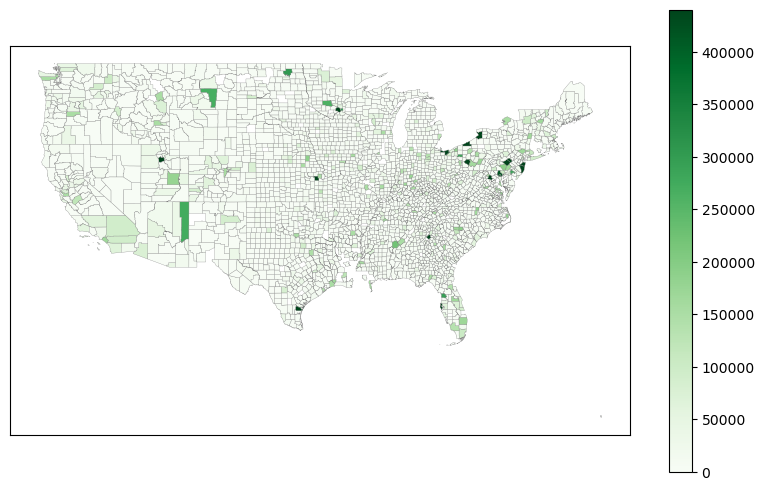

In [5]:
counties_to_remove = ["Hawaii", "Kalawao", "Honolulu", "Maui", "Kauai", "Juneau"]
merged_geo_df = merged_geo_df[~merged_geo_df["NAME"].isin(counties_to_remove)]

merged_geo_df["Imputed"] = np.where(merged_geo_df["Imputed"] >= merged_geo_df["Imputed"].std()*4, merged_geo_df["Imputed"].std()*4, merged_geo_df["Imputed"])

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_geo_df.plot(column="Imputed", cmap='Greens', linewidth=0.2, ax=ax, edgecolor='gray', legend=True)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title(year)
plt.show()

In [6]:
filtered_top_10_imputed = merged_geo_df[merged_geo_df['NAME'] != 'Erie'][['Imputed', 'NAME']].sort_values(by='Imputed', ascending=False).head(10)
filtered_top_10_imputed

,Imputed,NAME
10666,440456.132739,Loudoun
9535,440456.132739,Ocean
14134,440456.132739,Lorain
8781,440456.132739,Salt Lake
12045,440456.132739,Gwinnett
14040,440456.132739,Pinellas
8913,440456.132739,Hennepin
14028,440456.132739,Lehigh
13437,440456.132739,Shawnee
13060,440456.132739,Nueces


In [7]:
filtered_df = filtered_df[['ID', 'Imputed', 'Impute_Percent', 'State ID', 'County ID', 'County Area Name', 'ZIP']]

In [8]:
shapefile_path = "US County.shp"
gdf = gpd.read_file(shapefile_path)
file_path = "US Census 2.csv"
census = pd.read_csv(file_path)

In [9]:
file_path = "US County.csv"
df = pd.read_csv(file_path)

df.columns = df.iloc[0]
df = df[1:]
df = df.iloc[1:]
df = df.iloc[:-6]
df['Geographic Area'] = df['Geographic Area'].str.replace(r'^\.', '').str.split(' County').str[0]
df = df[['Geographic Area', '2012']]
df['2012'] = pd.to_numeric(df['2012'].str.replace(',', ''), errors='coerce')

In [10]:
merged_df = pd.merge(df, filtered_df, left_on='Geographic Area', right_on='County Area Name', how='inner')
merged_df = merged_df.drop_duplicates(subset=['ID'])
merged_df = merged_df.rename(columns={'2012': '2012 Population'})

In [11]:
merged_census = pd.merge(census, merged_df, left_on='ZIP_CODE', right_on='ZIP', how='inner')

In [12]:
merged_census = merged_census.sort_values(by='County Area Name')

In [13]:
df = merged_census
df = df.drop(['ZIP_CODE', 'STATE', 'ZCTA', 'ZIP', 'Geographic Area', 'ID', 'County Area Name', 'State ID', 'County ID', 'Impute_Percent', 'lpop'], axis=1)

In [14]:
# Split the data into features (X) and the target variable (y)
X = df.drop('2012 Population', axis=1)
y = df['2012 Population']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
warnings.filterwarnings("ignore")
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb = xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/jjwei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/jjwei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/jjwei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/jjwei/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:22:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent"

0.0629502358802887
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize the XGBoost regressor
xgb_model1 = XGBRegressor(min_child_weight=5)
xgb_model2 = XGBRegressor(n_estimators=200, max_depth=5)
xgb_model3 = XGBRegressor(colsample_bytree=0.7, learning_rate =0.03, max_depth =7, min_child_weight =4, n_estimators=500, nthread =4, objective ='reg:linear', silent =1, subsample=0.7)



# Train the model
xgb_model1.fit(X_train, y_train)
xgb_model2.fit(X_train, y_train)
xgb_model3.fit(X_train, y_train)

# Predict on the test set
y_pred1 = xgb_model1.predict(X_test)
y_pred2 = xgb_model2.predict(X_test)
y_pred3 = xgb_model3.predict(X_test)

# Evaluate the model
mse = sqrt(mean_squared_error(y_test, y_pred1))
print(f'Mean Squared Error 1: {mse}')
mse = sqrt(mean_squared_error(y_test, y_pred2))
print(f'Mean Squared Error 2: {mse}')
mse = sqrt(mean_squared_error(y_test, y_pred3))
print(f'Mean Squared Error 3: {mse}')

Mean Squared Error 1: 415409.26411140023
Mean Squared Error 2: 411256.69785808463
Mean Squared Error 3: 413479.1656875175


In [17]:
import shap
from sklearn.model_selection import train_test_split

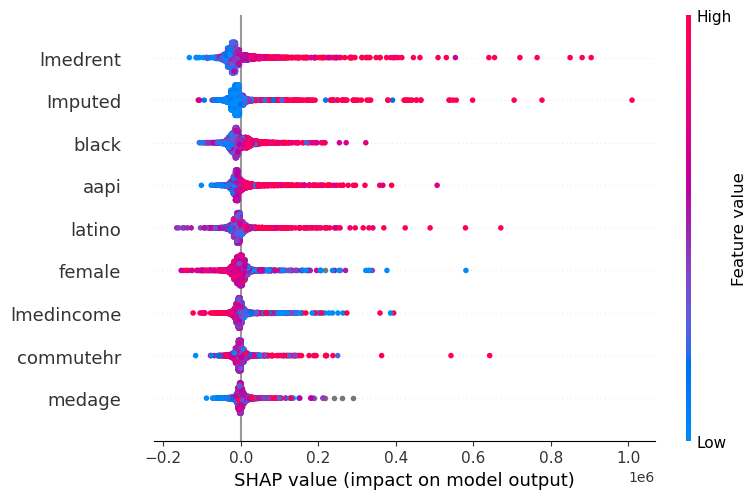

In [18]:
explainer = shap.TreeExplainer(xgb_model3)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [19]:
# Another way to plot importance
xgb.plot_importance(xgb_model3)
plt.title("xgboost.plot_importance(xgb_model3)")
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'plot_importance'

In [ ]:
correlations = df.drop('2012 Population', axis=1).corrwith(df['2012 Population'])
correlation_df = pd.DataFrame({'Pearson Correlation': correlations})

In [235]:
correlation_df

,Pearson Correlation
female,-0.078711
medage,-0.110240
black,0.119982
aapi,0.186048
latino,0.132952
commutehr,0.034741
lmedrent,0.262749
lmedincome,0.038900
Imputed,0.147590
